# Pyspark ETL

## Processamento inicial dos dados

In [ ]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import to_date

In [ ]:
# Configurar variáveis para acessar HDFS (caso necessário)
os.environ["HADOOP_USER_NAME"] = "root"  # executa operações no HDFS como usuário root

In [ ]:
# Iniciar sessão Spark
spark = SparkSession.builder \
    .appName("SiasusETL") \
    .getOrCreate()

In [ ]:
# Ler o arquivo CSV do HDFS
# vamos definir esquemas manualmente em alguns casos
# encoding Latin-1 para caracteres especiais
df = spark.read.format("csv") \
    .option("header", True) \
    .option("inferSchema", False) \
    .option("sep", ",") \
    .option("encoding", "ISO-8859-1") \
    .load("hdfs://localhost:9000/user/root/siasus/PSRS2301.csv")

In [ ]:
df.printSchema()
df.show(5)

In [ ]:
from pyspark.sql.functions import col, trim, upper, when

# Exemplo 1: Renomear coluna com espaços e normalizar strings
df = df.withColumnRenamed("TIPPRE  ", "TIPPRE")  # remove espaços do nome da coluna
df = df.withColumn("CONDIC", upper(trim(col("CONDIC"))))  # normaliza CONDIC para maiúsculo sem espaços extras

# Exemplo 2: Converter tipos de dados
df = df.withColumn("IDADEPAC", col("IDADEPAC").cast(IntegerType()))
df = df.withColumn("PA_QTDPRO", col("PA_QTDPRO").cast(IntegerType()))
df = df.withColumn("PA_QTDAPR", col("PA_QTDAPR").cast(IntegerType()))

df = df.withColumn(
    "DTNASC",                      
    to_date(col("DTNASC"), "yyyyMMdd") 
)

# Exemplo 3: Filtrar registros inválidos (caso IDADEPAC não seja plausível, por ex: > 120 anos ou < 0)
df = df.filter((col("IDADEPAC") >= 0) & (col("IDADEPAC") < 120))

# Exemplo 4: Enriquecimento - criar faixa etária
df = df.withColumn(
    "FAIXA_ETARIA",
    when(col("IDADEPAC") < 18, "MENOR")
     .when((col("IDADEPAC") >= 18) & (col("IDADEPAC") < 60), "MAIOR")
     .when(col("IDADEPAC") >= 60, "IDOSO")
)

In [ ]:
# df.summary().show()

In [ ]:
json_rdd = df.toJSON().collect()

print(f"Total de registros a enviar: {len(json_rdd)}")
print("Exemplo de registro JSON:", json_rdd[0])

## Producer

In [ ]:
from kafka import KafkaProducer

In [ ]:
# Configura o produtor Kafka (envio de strings, então usaremos encoding de UTF-8)
producer = KafkaProducer(bootstrap_servers=['localhost:9092'], 
                         value_serializer=lambda v: v.encode('utf-8'))

In [ ]:
topic_name = "atendimentos_psicossociais"

# Envia cada mensagem JSON para o tópico
for record in json_rdd:
    producer.send(topic_name, value=record)

In [ ]:
# Força envio de qualquer mensagem pendente
producer.flush()
producer.close()

In [ ]:
print(f"{len(json_rdd)} mensagens enviadas para o tópico '{topic_name}'.")

docker exec -it kafka bash
kafka-console-consumer.sh --bootstrap-server localhost:9092 --topic andimentos_psicossociais --from-beginning


## Consumer

In [ ]:
from kafka import KafkaConsumer
from pymongo import MongoClient
import json
import time

topic_name = "atendimentos_psicossociais"

mongo_client = MongoClient("localhost", 27017)
db = mongo_client["siasus"]
collection = db["atendimentos"]

consumer = KafkaConsumer(
    topic_name,
    bootstrap_servers=['localhost:9092'],
    auto_offset_reset='earliest',
    enable_auto_commit=True,
    group_id="grupo-siasus-1",
    value_deserializer=lambda v: v.decode('utf-8')
)

batch_size = 10000
batch = []
count = 0

# Controla tempo sem mensagens
max_empty_polls = 10
empty_polls = 0

try:
    while True:
        raw_msgs = consumer.poll(timeout_ms=1000)  # 1 segundo esperando mensagens

        if not raw_msgs:
            empty_polls += 1
            if empty_polls >= max_empty_polls:
                print("Nenhuma mensagem nova após várias tentativas, encerrando consumo...")
                break
            continue
        else:
            empty_polls = 0  # reset se chegou mensagem

        for tp, messages in raw_msgs.items():
            for msg in messages:
                registro = json.loads(msg.value)
                batch.append(registro)
                count += 1

                if len(batch) >= batch_size:
                    collection.insert_many(batch)
                    print(f"Inseridos {count} registros (último batch de {len(batch)})...")
                    batch.clear()

except KeyboardInterrupt:
    print("Interrupção manual. Finalizando...")

finally:
    if batch:
        collection.insert_many(batch)
        print(f"Inseridos {count} registros (último batch incompleto de {len(batch)})...")

    print(f"Consumo finalizado. Total de registros inseridos: {count}")


In [ ]:
print(collection.count_documents({}))
# ou, para ver um exemplo de documento:
doc = collection.find_one()
print(doc)

## Análise exploratória

In [33]:
import pandas as pd
import json
from collections import Counter
import matplotlib.pyplot as plt

# Recupere todos os documentos da coleção (cuidado: se fosse muito grande, poderíamos filtrar ou limitar)
docs = list(collection.find({}))  # converte cursor em lista de documentos
df_pd = pd.DataFrame(docs)

print(df_pd.shape)        # deve ser (82233, número_de_colunas+_id)
print(df_pd.columns[:10]) # ver as primeiras colunas disponíveis

(82233, 47)
Index(['_id', 'CNES_EXEC', 'GESTAO', 'CONDIC', 'UFMUN', 'TPUPS', 'TIPPRE',
       'MN_IND', 'CNPJCPF', 'CNPJMNT'],
      dtype='object')


### Distribuição do número de atendimentos psicossociais por sexo do paciente em Jan/2023

In [34]:
#Distribuição por sexo dos pacientes: Quantos atendimentos foram para pacientes do sexo masculino vs feminino? Isso pode indicar perfil demográfico do atendimento psicossocial.
contagem_sexo = df_pd['SEXOPAC'].value_counts()
porcentagem_sexo = df_pd['SEXOPAC'].value_counts(normalize=True) * 100

distribuicao_sexo = pd.DataFrame({
    'Quantidade': contagem_sexo,
    'Porcentagem (%)': porcentagem_sexo
})

print(distribuicao_sexo)

         Quantidade  Porcentagem (%)
SEXOPAC                             
M             44825        54.509747
F             37408        45.490253


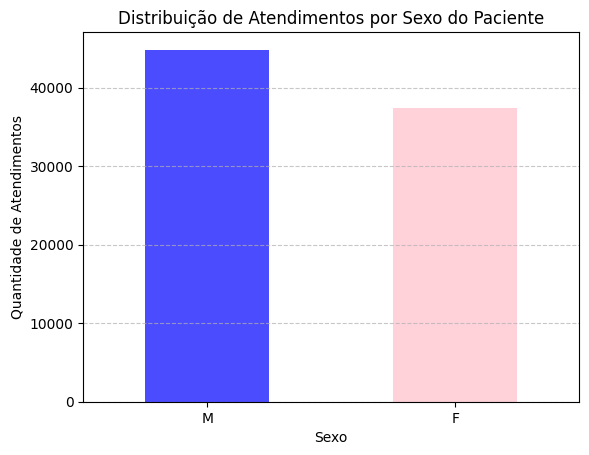

In [35]:
# Criar o gráfico de barras
contagem_sexo.plot(kind='bar', color=['blue', 'pink'], alpha=0.7)

# Configurar o gráfico
plt.title("Distribuição de Atendimentos por Sexo do Paciente")
plt.xlabel("Sexo")
plt.ylabel("Quantidade de Atendimentos")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Exibir o gráfico
plt.show()

### Atendimentos por faixa etária

In [36]:
# Distribuição por faixa etária: Quantos atendimentos foram para cada faixa etária?
contagem_faixa_etaria = df_pd['FAIXA_ETARIA'].value_counts()
porcentagem_faixa_etaria = df_pd['FAIXA_ETARIA'].value_counts(normalize=True) * 100

distribuicao_faixa_etaria = pd.DataFrame({
    'Quantidade': contagem_faixa_etaria,
    'Porcentagem (%)': porcentagem_faixa_etaria
})

print(distribuicao_faixa_etaria)

              Quantidade  Porcentagem (%)
FAIXA_ETARIA                             
MAIOR              61218        74.444566
MENOR              16575        20.156142
IDOSO               4440         5.399292


In [ ]:
# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
contagem_faixa_etaria.plot(kind='bar', color=['blue', 'green', 'orange'])

# Configurar o gráfico
plt.title("Distribuição de Atendimentos por Faixa Etária")
plt.xlabel("Faixa Etária")
plt.ylabel("Quantidade de Atendimentos")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar valores sobre as barras
for i, v in enumerate(contagem_faixa_etaria):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Ajustar layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

NameError: name 'faixas_etarias' is not defined

### Diagnósticos mais frequentes

In [ ]:
# Número de top CIDs a exibir
num_top_cids = 5

# Contar a frequência de cada CID
contagem_cids = df_pd['CIDPRI'].value_counts()

# Calcular as porcentagens
porcentagem_cids = contagem_cids / contagem_cids.sum() * 100

# Selecionar os top CIDs
top_cids_count = contagem_cids.head(num_top_cids)
top_cids_percent = porcentagem_cids.head(num_top_cids)

# Calcular valores para "Outros"
count_outros = contagem_cids.sum() - top_cids_count.sum()
percent_outros = 100 - top_cids_percent.sum()

# Criar DataFrame com os resultados
distribuicao_cids = pd.DataFrame({
    'CID': list(top_cids_count.index) + ['Outros'],
    'Quantidade': list(top_cids_count.values) + [count_outros],
    'Porcentagem (%)': list(top_cids_percent.values) + [percent_outros]
})

# Formatar a coluna de porcentagem para 2 casas decimais
distribuicao_cids['Porcentagem (%)'] = distribuicao_cids['Porcentagem (%)'].round(2)

print(distribuicao_cids)

In [ ]:
# Criar figura com tamanho personalizado
plt.figure(figsize=(10, 8))

# Criar gráfico de pizza
plt.pie(distribuicao_cids['Quantidade'], 
        labels=distribuicao_cids['CID'],
        autopct='%1.1f%%',
        colors=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC', '#99CCFF'],
        explode=[0.05] * len(distribuicao_cids))  # pequena separação de todas as fatias

# Adicionar título
plt.title('Distribuição dos Diagnósticos (CID) mais Frequentes', pad=20)

# Adicionar legenda
plt.legend(distribuicao_cids['CID'], 
          title="CIDs",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

# Ajustar layout para não cortar a legenda
plt.tight_layout()

# Mostrar o gráfico
plt.show()

### Estabelecimentos e municípios

In [ ]:
print("Estabelecimentos únicos (CNES_EXEC):", df_pd['CNES_EXEC'].nunique())
print("Municípios únicos (MUNPAC):", df_pd['MUNPAC'].nunique())